<a href="https://colab.research.google.com/github/sv650s/atp-tennis-predictions/blob/dataset2/notebooks/5.0.1-classification-1layer_nn-3xfeatures-ordinal-history5_win_perc-stats5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ATP Tennis Data - NN Using One Hot Encoding

In this notebook, I we will run our data through a 1 layer NN where number of hidden units is 3x number of features

Columns that will be used in this notebook are:
* raw ordinal features -ie, p1/p2_rank, p1/p2_height
* history win percentage for each player for the last 5 maches
* raw player stats from last 5 maches

We will compare the results of the NN with the Gradient Boosting model

```
Model Score: 0.6829169480081027

ROC/AUC Score: 0.6829166839061929
              precision    recall  f1-score   support

        Loss       0.68      0.68      0.68     14815
         Win       0.68      0.68      0.68     14805

    accuracy                           0.68     29620
   macro avg       0.68      0.68      0.68     29620
weighted avg       0.68      0.68      0.68     29620
```

# Results


In [1]:
from google.colab import drive
drive.mount('/content/drive')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
%tensorflow_version 2.x


import tensorflow as tf
# checl to make sure we are using GPU here
tf.test.gpu_device_name()

TensorFlow 2.x selected.


'/device:GPU:0'

In [3]:
import sys
import pandas as pd
import numpy as np
from datetime import datetime
import pickle
import json
import sys
import matplotlib.pyplot as plt
import seaborn as sns
import logging

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import OneHotEncoder

from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.layers.normalization import BatchNormalization
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.optimizers import SGD

# add our google drive directory to path so we can load custom modules
DRIVE_DIR = "drive/My Drive/Springboard/capstone2"
sys.path.append(DRIVE_DIR)
import util.model_util as mu
from util.model_util import LABEL_COL, RSTATE


logging.basicConfig(level=logging.INFO)
%matplotlib inline
sns.set()

tf.test.gpu_device_name()

Using TensorFlow backend.


'/device:GPU:0'

In [0]:
DATASET_DIR = f'{DRIVE_DIR}/datasets'
MODEL_DIR = f'{DRIVE_DIR}/models'
REPORT_DIR = f'{DRIVE_DIR}/reports'

START_YEAR = 1998
END_YEAR = 2018

DEBUG = False
MODEL_NAME = 'nn_1layer-3xfeatures-ordinal-history5_win_perc-stats5'


if DEBUG:
  FEATURE_FILE = f'{DATASET_DIR}/atp_matches_1985-2019_features_test-raw_diff-ohe-history-matchup-stats.csv'
  MODEL_NAME = f'{MODEL_NAME}-test'
  mu.ModelWrapper.REPORT_FILE = f'{DRIVE_DIR}/reports/summary-test.csv'
  mu.ModelWrapper.MODEL_DIR = f'{DRIVE_DIR}/models'
else:
  FEATURE_FILE = f'{DATASET_DIR}/atp_matches_1985-2019_features-raw_diff-ohe-history-matchup-stats.csv'
  mu.ModelWrapper.REPORT_FILE = f'{DRIVE_DIR}/reports/summary.csv'
  mu.ModelWrapper.MODEL_DIR = f'{DRIVE_DIR}/models'


In [5]:
filters = ["util.model_util.BaseOrdinalFilter", "util.model_util.History5WinPercentageFilter", "util.model_util.Stats5RawFilter"]
MODEL_BASENAME = f'{MODEL_DIR}/{MODEL_NAME}'


features, labels = mu.ModelWrapper.get_data(FEATURE_FILE, LABEL_COL, START_YEAR, END_YEAR, column_filters = filters,
                                                split_train_test = False)
print(features.shape)
print(labels.head())
features.head()

INFO:util.model_util:Adding filter: util.model_util.BaseOrdinalFilter
INFO:util.model_util:Adding filter: util.model_util.History5WinPercentageFilter
INFO:util.model_util:Adding filter: util.model_util.Stats5RawFilter
INFO:util.model_util:loading drive/My Drive/Springboard/capstone2/datasets/atp_matches_1985-2019_features-raw_diff-ohe-history-matchup-stats.csv
INFO:util.model_util:Shape before filtering: (118478, 5464)
INFO:util.model_util:Shape after filtering: (118478, 31)
INFO:util.model_util:Final Features shape: (118478, 31)


(118478, 31)
81324    1
81325    0
81326    1
81327    0
81328    1
Name: p1_winner, dtype: int64


,draw_size,round_label,tourney_level_label,tourney_month,tourney_year,p1_age,p1_ht,p1_rank,p2_age,p2_ht,p2_rank,p1_history5_win_percentage,p2_history5_win_percentage,p1_stats5_1stin,p1_stats5_1stwon,p1_stats5_2ndwon,p1_stats5_ace,p1_stats5_bpfaced,p1_stats5_bpsaved,p1_stats5_df,p1_stats5_svgms,p1_stats5_svpt,p2_stats5_1stin,p2_stats5_1stwon,p2_stats5_2ndwon,p2_stats5_ace,p2_stats5_bpfaced,p2_stats5_bpsaved,p2_stats5_df,p2_stats5_svgms,p2_stats5_svpt
81324,32,5,4,1,1998,25.79,183.0,4,26.61,188.0,74,0.6,0.4,36,26,14,6,6,4,2,9,65,45,31,16,4,7,4,2,12,76
81325,32,5,4,1,1998,26.61,188.0,74,25.79,183.0,4,0.4,0.6,45,31,16,4,7,4,2,12,76,36,26,14,6,6,4,2,9,65
81326,32,5,4,1,1998,27.76,185.0,79,22.85,175.0,87,0.4,0.4,43,33,20,8,6,3,3,13,82,46,26,10,0,8,3,3,10,68
81327,32,5,4,1,1998,22.85,175.0,87,27.76,185.0,79,0.4,0.4,46,26,10,0,8,3,3,10,68,43,33,20,8,6,3,3,13,82
81328,32,5,4,1,1998,21.76,185.0,93,23.08,185.0,71,0.4,0.2,38,27,13,5,7,5,1,9,64,39,31,11,9,4,2,2,11,68


In [6]:
# one hot encode our labels for Keras
label_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
labels_encoded = label_encoder.fit_transform(pd.DataFrame(labels))
labels_encoded[:5]

array([[0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.]])

In [0]:
# split into training and test set
X_train, X_test, y_train_encoded, y_test_encoded = train_test_split(features, labels_encoded)
y_test = label_encoder.inverse_transform(y_test_encoded)

In [8]:
X_train.shape

(88858, 31)

# Implement Neural Network



In [9]:
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense, Activation, BatchNormalization
from tensorflow.keras import regularizers
import tensorflow.keras as K

RSTATE = 1

output_dim = nb_classes = 2
model_lr = Sequential() 
model_lr.add(Dense(X_train.shape[1] * 2, 
                   input_shape=(X_train.shape[1], ),
                   kernel_regularizer=regularizers.l2(0.01),
                   kernel_initializer=K.initializers.glorot_uniform(seed=RSTATE))) 
model_lr.add(BatchNormalization())
model_lr.add(Activation("relu"))


model_lr.add(Dense(output_dim, 
                   kernel_initializer=K.initializers.glorot_uniform(seed=RSTATE))) 
model_lr.add(Activation("softmax"))
batch_size = 129 
epochs = 100

model_lr.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['accuracy']) 

model_json = model_lr.to_json()
with open(f'{MODEL_BASENAME}.json', 'w') as file:
  file.write(model_json)

model_lr.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 62)                1984      
_________________________________________________________________
batch_normalization (BatchNo (None, 62)                248       
_________________________________________________________________
activation (Activation)      (None, 62)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 126       
_________________________________________________________________
activation_1 (Activation)    (None, 2)                 0         
Total params: 2,358
Trainable params: 2,234
Non-trainable params: 124
_________________________________________________________________


In [10]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

callbacks = [EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1),
             ModelCheckpoint(filepath=f'{MODEL_BASENAME}.h5', monitor='val_loss', save_best_only=True),
             ReduceLROnPlateau(monitor='val_loss', factor=0.4,patience=2, min_lr=0.00001, mode='auto')]


history = model_lr.fit(X_train, y_train_encoded, 
                       batch_size=batch_size, 
                       epochs=epochs,
                       verbose=1, 
                       validation_split=0.2,
                       callbacks=callbacks) 

# evalute our model
score = model_lr.evaluate(X_test, y_test_encoded, verbose=0) 
print('Test score:', score[0]) 
print('Test accuracy:', score[1])

Train on 71086 samples, validate on 17772 samples
Epoch 1/100
71086/71086 [==============================] - 4s 62us/sample - loss: 1.0122 - accuracy: 0.6372 - val_loss: 0.9656 - val_accuracy: 0.6426
Epoch 2/100
71086/71086 [==============================] - 3s 39us/sample - loss: 0.9262 - accuracy: 0.6482 - val_loss: 0.9116 - val_accuracy: 0.6293
Epoch 3/100
71086/71086 [==============================] - 3s 39us/sample - loss: 0.8665 - accuracy: 0.6481 - val_loss: 0.8775 - val_accuracy: 0.6244
Epoch 4/100
71086/71086 [==============================] - 3s 39us/sample - loss: 0.8185 - accuracy: 0.6492 - val_loss: 0.8087 - val_accuracy: 0.6370
Epoch 5/100
71086/71086 [==============================] - 3s 38us/sample - loss: 0.7799 - accuracy: 0.6490 - val_loss: 0.7779 - val_accuracy: 0.6270
Epoch 6/100
71086/71086 [==============================] - 3s 38us/sample - loss: 0.7491 - accuracy: 0.6494 - val_loss: 0.7656 - val_accuracy: 0.6301
Epoch 7/100
71086/71086 [=========================

Test score: 0.6407198731034772
Test accuracy: 0.653815


In [11]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])

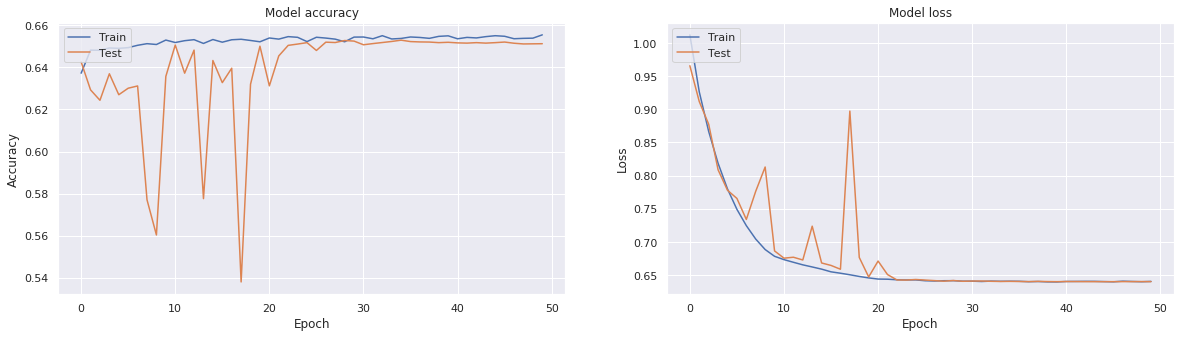

In [12]:
f, a = plt.subplots(1, 2, figsize=(20, 5))

# Plot training & validation accuracy values
a[0].plot(history.history['accuracy'])
a[0].plot(history.history['val_accuracy'])
a[0].set_title('Model accuracy')
a[0].set_ylabel('Accuracy')
a[0].set_xlabel('Epoch')
a[0].legend(['Train', 'Test'], loc='upper left')
# plt.show()

# Plot training & validation loss values
a[1].plot(history.history['loss'])
a[1].plot(history.history['val_loss'])
a[1].set_title('Model loss')
a[1].set_ylabel('Loss')
a[1].set_xlabel('Epoch')
a[1].legend(['Train', 'Test'], loc='upper left')
plt.show()

In [13]:
# use our model to predict
y_predict_encoded = model_lr.predict(X_test)


In [14]:
y_predict_encoded[:20]

array([[0.16519675, 0.8348032 ],
       [0.27127987, 0.7287201 ],
       [0.48276538, 0.5172346 ],
       [0.7620422 , 0.2379578 ],
       [0.49705637, 0.50294363],
       [0.371991  , 0.628009  ],
       [0.55545855, 0.4445415 ],
       [0.24796061, 0.7520394 ],
       [0.69959897, 0.300401  ],
       [0.7571123 , 0.24288763],
       [0.57419527, 0.42580473],
       [0.22460724, 0.7753927 ],
       [0.5348276 , 0.46517238],
       [0.6302256 , 0.36977443],
       [0.8034236 , 0.19657642],
       [0.14709137, 0.8529086 ],
       [0.4629873 , 0.5370127 ],
       [0.64997286, 0.3500271 ],
       [0.32009107, 0.679909  ],
       [0.7623494 , 0.23765054]], dtype=float32)

In [15]:
y_predict = [row.idxmax() for index, row in pd.DataFrame(y_predict_encoded).iterrows()]
y_predict[:20]

[1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0]

In [0]:

mw = mu.ModelWrapper(model_lr, MODEL_NAME, FEATURE_FILE, START_YEAR, END_YEAR, 
                  X_train = X_train, 
                  y_train = label_encoder.inverse_transform(y_train_encoded), 
                  X_test = X_test, y_test = y_test, model_name = MODEL_NAME)
mw.y_predict = y_predict

INFO:numexpr.utils:NumExpr defaulting to 4 threads.


Model Score: 0.6538149898717083

ROC/AUC Score: 0.6538324885612544
              precision    recall  f1-score   support

        Loss       0.66      0.65      0.65     14876
         Win       0.65      0.66      0.65     14744

    accuracy                           0.65     29620
   macro avg       0.65      0.65      0.65     29620
weighted avg       0.65      0.65      0.65     29620

      Loss   Win
Loss  9668  5208
Win   5046  9698


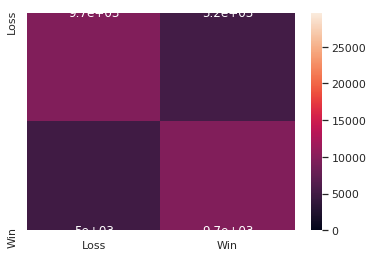

In [17]:
mw.analyze()

In [18]:
mw.save(save_model = False)

INFO:util.model_util:Reading report: drive/My Drive/Springboard/capstone2/reports/summary.csv


Saving report: drive/My Drive/Springboard/capstone2/reports/summary.csv


In [19]:
print(f'Last Finished: {datetime.now().strftime("%Y-%m-%d %H:%M")}')

Last Finished: 2019-11-01 23:54
